In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from unittest.mock import inplace
from IPython.display import set_matplotlib_formats
from yellowbrick.cluster import KElbowVisualizer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, KFold
from random import randint

from scipy.io import loadmat
import seaborn as sns
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import math
import time
import datetime
import warnings
import mariadb
import pymysql

warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
warnings.filterwarnings(action='ignore')
#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)

# Korean Font Setting
plt.rcParams["font.family"] = 'Malgun Gothic'

In [48]:
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
display(dataset)
dataset.describe() 

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  \
0          1                   24 2008-04-02 15:25:41  1.856487   
1          1                   24 2008-04-02 15:25:41  1.856487   
2          1                   24 2008-04-02 15:25:41  1.856487   
3          1                   24 2008-04-02 15:25:41  1.856487   
4          1                   24 2008-04-02 15:25:41  1.856487   
...      ...                  ...                 ...       ...   
50280    168                   24 2008-05-27 20:45:42  1.325079   
50281    168                   24 2008-05-27 20:45:42  1.325079   
50282    168                   24 2008-05-27 20:45:42  1.325079   
50283    168                   24 2008-05-27 20:45:42  1.325079   
50284    168                   24 2008-05-27 20:45:42  1.325079   

       voltage_measured  current_measured  temperature_measured  current_load  \
0              4.191492         -0.004902             24.330034       -0.0006   
1              4.190749         -0.001478             24.325993       -0.0006   
2              3.974871         -2.012528             24.389085       -1.9982   
3              3.951717         -2.013979             24.544752       -1.9982   
4              3.934352         -2.011144             24.731385       -1.9982   
...                 ...               ...                   ...           ...   
50280          3.579262         -0.001569             34.864823        0.0006   
50281          3.581964         -0.003067             34.814770        0.0006   
50282          3.584484         -0.003079             34.676258        0.0006   
50283          3.587336          0.001219             34.565580        0.0006   
50284          3.589937         -0.000583             34.405920        0.0006   

       voltage_load      time  
0             0.000     0.000  
1             4.206    16.781  
2             3.062    35.703  
3             3.030    53.781  
4             3.011    71.922  
...             ...       ...  
50280         0.000  2781.312  
50281         0.000  2791.062  
50282         0.000  2800.828  
50283         0.000  2810.640  
50284         0.000  2820.390  

[50285 rows x 10 columns]

cycle  ambient_temperature      capacity  voltage_measured  \
count  50285.000000              50285.0  50285.000000      50285.000000   
mean      88.125942                 24.0      1.560345          3.515268   
std       45.699687                  0.0      0.182380          0.231778   
min        1.000000                 24.0      1.287453          2.455679   
25%       50.000000                 24.0      1.386229          3.399384   
50%       88.000000                 24.0      1.538237          3.511664   
75%      127.000000                 24.0      1.746871          3.660903   
max      168.000000                 24.0      1.856487          4.222920   

       current_measured  temperature_measured  current_load  voltage_load  \
count      50285.000000          50285.000000  50285.000000  50285.000000   
mean          -1.806032             32.816991      1.362700      2.308406   
std            0.610502              3.987515      1.313698      0.800300   
min           -2.029098             23.214802     -1.998400      0.000000   
25%           -2.013415             30.019392      1.998000      2.388000   
50%           -2.012312             32.828944      1.998200      2.533000   
75%           -2.011052             35.920887      1.998200      2.690000   
max            0.007496             41.450232      1.998400      4.238000   

               time  
count  50285.000000  
mean    1546.208924  
std      906.640295  
min        0.000000  
25%      768.563000  
50%     1537.031000  
75%     2305.984000  
max     3690.234000

Text(0.5, 1.0, 'Discharge B0005')

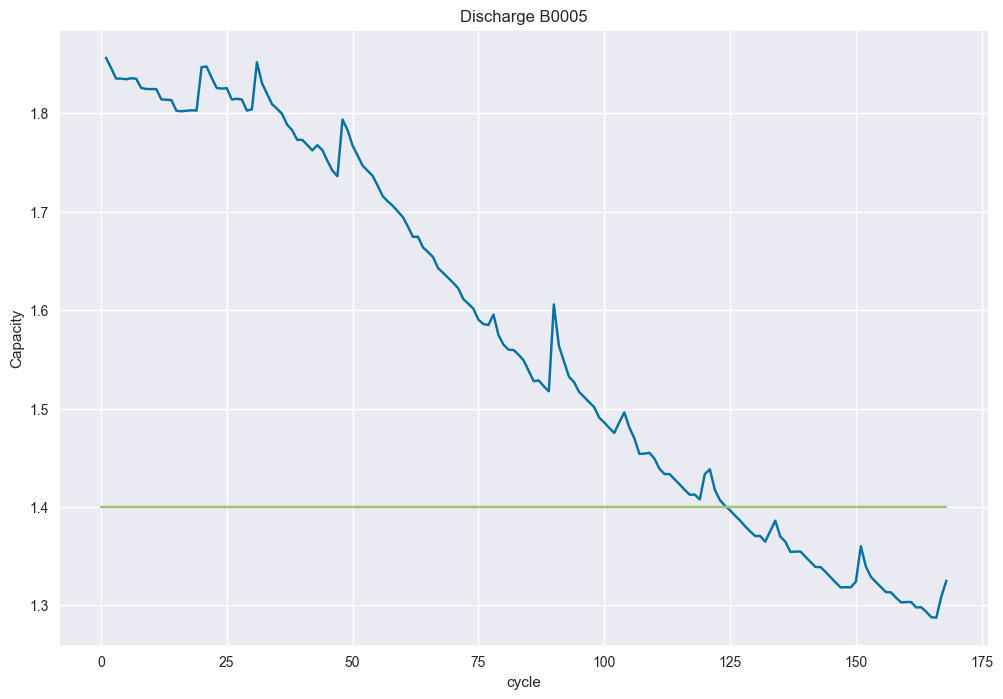

In [49]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [50]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Text(0.5, 1.0, 'Discharge B0005')

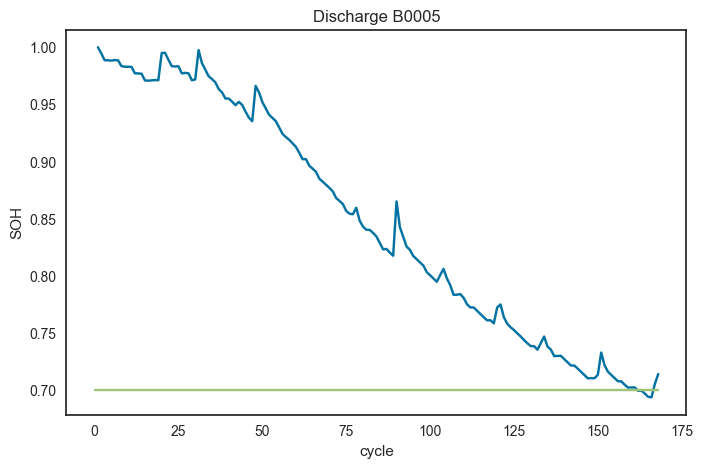

In [51]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [52]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['cycle','capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
train_dataset = pd.concat([train_dataset, soh], axis=1)


## Residual Forecasting

In [53]:
df_soh = dataset.copy()
df_soh = pd.concat([df_soh, soh], axis=1)
df_soh.set_index(['datetime'], inplace=True)
df_soh

cycle  ambient_temperature  capacity  voltage_measured  \
datetime                                                                      
2008-04-02 15:25:41      1                   24  1.856487          4.191492   
2008-04-02 15:25:41      1                   24  1.856487          4.190749   
2008-04-02 15:25:41      1                   24  1.856487          3.974871   
2008-04-02 15:25:41      1                   24  1.856487          3.951717   
2008-04-02 15:25:41      1                   24  1.856487          3.934352   
...                    ...                  ...       ...               ...   
2008-05-27 20:45:42    168                   24  1.325079          3.579262   
2008-05-27 20:45:42    168                   24  1.325079          3.581964   
2008-05-27 20:45:42    168                   24  1.325079          3.584484   
2008-05-27 20:45:42    168                   24  1.325079          3.587336   
2008-05-27 20:45:42    168                   24  1.325079          3.589937   

                     current_measured  temperature_measured  current_load  \
datetime                                                                    
2008-04-02 15:25:41         -0.004902             24.330034       -0.0006   
2008-04-02 15:25:41         -0.001478             24.325993       -0.0006   
2008-04-02 15:25:41         -2.012528             24.389085       -1.9982   
2008-04-02 15:25:41         -2.013979             24.544752       -1.9982   
2008-04-02 15:25:41         -2.011144             24.731385       -1.9982   
...                               ...                   ...           ...   
2008-05-27 20:45:42         -0.001569             34.864823        0.0006   
2008-05-27 20:45:42         -0.003067             34.814770        0.0006   
2008-05-27 20:45:42         -0.003079             34.676258        0.0006   
2008-05-27 20:45:42          0.001219             34.565580        0.0006   
2008-05-27 20:45:42         -0.000583             34.405920        0.0006   

                     voltage_load      time       SoH  
datetime                                               
2008-04-02 15:25:41         0.000     0.000  1.000000  
2008-04-02 15:25:41         4.206    16.781  1.000000  
2008-04-02 15:25:41         3.062    35.703  1.000000  
2008-04-02 15:25:41         3.030    53.781  1.000000  
2008-04-02 15:25:41         3.011    71.922  1.000000  
...                           ...       ...       ...  
2008-05-27 20:45:42         0.000  2781.312  0.713756  
2008-05-27 20:45:42         0.000  2791.062  0.713756  
2008-05-27 20:45:42         0.000  2800.828  0.713756  
2008-05-27 20:45:42         0.000  2810.640  0.713756  
2008-05-27 20:45:42         0.000  2820.390  0.713756  

[50285 rows x 10 columns]

In [54]:
df_soh = df_soh['SoH']
# df_soh = pd.DataFrame(df_soh)
df_soh

datetime
2008-04-02 15:25:41    1.000000
2008-04-02 15:25:41    1.000000
2008-04-02 15:25:41    1.000000
2008-04-02 15:25:41    1.000000
2008-04-02 15:25:41    1.000000
                         ...   
2008-05-27 20:45:42    0.713756
2008-05-27 20:45:42    0.713756
2008-05-27 20:45:42    0.713756
2008-05-27 20:45:42    0.713756
2008-05-27 20:45:42    0.713756
Name: SoH, Length: 50285, dtype: float64

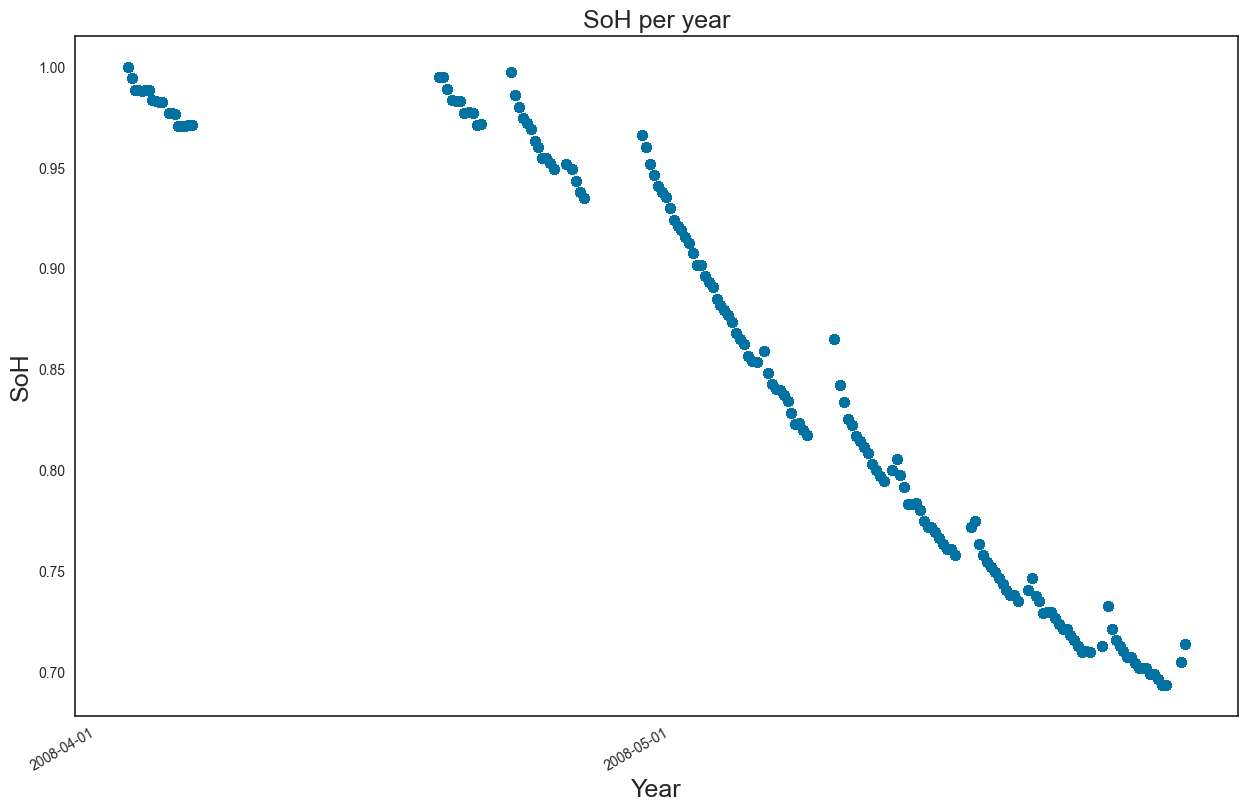

In [55]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_soh.index, df_soh)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.DayLocator(1))
# Add the title to the graph
plt.title('SoH per year', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('SoH', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()

In [56]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
# y_hat (difference -> scaling, unscaling -> undifference)
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value] # push_back
    array = np.array(new_row)
    array = array.reshape(1, len(array)) # convert to 2d
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [57]:
df_new = df_soh.drop_duplicates()

In [12]:
# df_new = df_soh

In [58]:
df_new

datetime
2008-04-02 15:25:41    1.000000
2008-04-02 19:43:48    0.994527
2008-04-03 00:01:06    0.988614
2008-04-03 04:16:37    0.988567
2008-04-03 08:33:25    0.988235
                         ...   
2008-05-26 10:44:38    0.696726
2008-05-26 15:30:43    0.693785
2008-05-26 20:21:04    0.693488
2008-05-27 15:52:41    0.705103
2008-05-27 20:45:42    0.713756
Name: SoH, Length: 168, dtype: float64

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [60]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]),stateful=True))
  model.add(Dense(1))

  model.compile(loss = 'mean_squared_error', optimizer='adam')

  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return model

def forecast_lstm(model, batch_size, X):
  # step, batch, 
  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size, verbose=0)
  return yhat[0,0]

In [61]:
series = pd.Series(df_new)
raw_values = series.values


diff_values = difference(raw_values, 1)
print(diff_values)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train_size = int(len(supervised_values) * 0.95)
train = supervised_values[0:train_size]
test = supervised_values[train_size:]

scaler, train_scaled, test_scaled = scale(train, test)


0     -0.005473
1     -0.005913
2     -0.000047
3     -0.000332
4      0.000547
         ...   
162   -0.002483
163   -0.002941
164   -0.000297
165    0.011615
166    0.008653
Length: 167, dtype: float64


In [70]:
repeats = 2

error_scores = list()

for r in range(repeats):

  lstm_model = fit_lstm(train_scaled, 1, 10, 4)
  predictions = list()

  for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler=scaler, X=X, value=yhat)

    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)

    predictions.append(yhat)

  rmse = np.sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
  print('%d) Test RMSE: %.3f' % (r+1, rmse))
  error_scores.append(rmse)


1) Test RMSE: 0.004
2) Test RMSE: 0.002


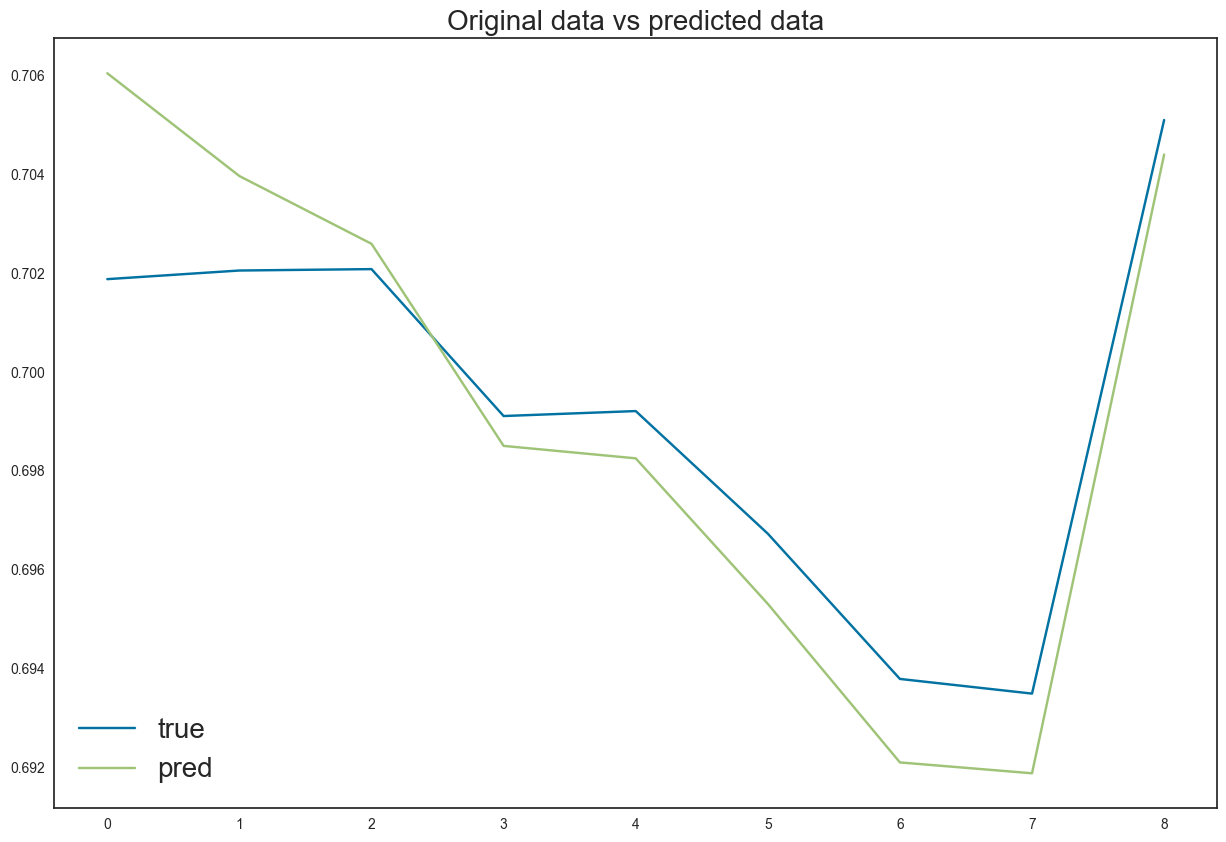

In [71]:
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)], label='true')
plt.plot(predictions, label='pred')
plt.legend(fontsize=20)
plt.title('Original data vs predicted data', fontsize=20)
plt.show()

In [19]:
last_value = np.array([test_scaled[-1][0]])

In [21]:
last_value

array([-0.02484574])

In [140]:
# initial record
initial = last_value
# store prediction
prediction = []
# set range to 40 for next 40 months prediction
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = invert_scale(scaler, initial, yhat)
    # invert differencing
    if i == 0:
        yhat_diff = yhat_inver + raw_values[-1]
    else:
        yhat_diff = yhat_inver + prediction[i-1] 
    # append to our prediction variable
    prediction.append(yhat_diff)
    # Re initial our initial variable 
    # to feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [141]:
prediction = pd.DataFrame(prediction)

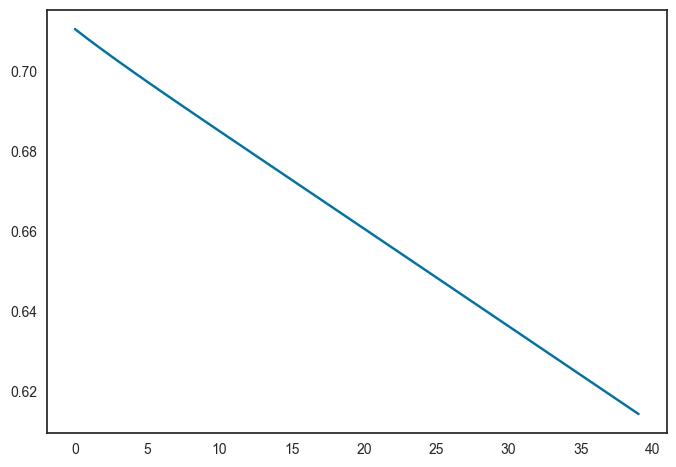

In [144]:
plt.plot(prediction.values)
# plt.ylim([0.71, 0.715])

In [64]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
display(dataset_val.head(5))
display(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.008730             24.515123       -1.9990         3.045  53.781  
4         -2.013381             24.676053       -1.9990         3.026  71.922

cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  2.035338  1.000000
1      2 2008-04-02 19:43:48  2.025140  0.994990
2      3 2008-04-03 00:01:06  2.013326  0.989185
3      4 2008-04-03 04:16:37  2.013285  0.989165
4      5 2008-04-03 08:33:25  2.000528  0.982898

In [65]:
inf_df = dis_ele[['datetime', 'SoH']]
inf_df.set_index(['datetime'], inplace=True)

In [66]:
inf_df

SoH
datetime                     
2008-04-02 15:25:41  1.000000
2008-04-02 19:43:48  0.994990
2008-04-03 00:01:06  0.989185
2008-04-03 04:16:37  0.989165
2008-04-03 08:33:25  0.982898
...                       ...
2008-05-26 10:44:38  0.566893
2008-05-26 15:30:43  0.572092
2008-05-26 20:21:04  0.569339
2008-05-27 15:52:41  0.577287
2008-05-27 20:45:42  0.582545

[168 rows x 1 columns]

In [67]:
# series_n = pd.Series(inf_df)
raw_values_n = inf_df.values
diff_values_n = difference(raw_values_n, 1)
print(diff_values_n)

supervised_n = timeseries_to_supervised(diff_values_n, 1)
supervised_values_n = supervised_n.values

inference_scaled = scaler.transform(supervised_values_n)

0       [-0.005010149185692647]
1       [-0.005804380923417618]
2      [-2.049085365840586e-05]
3       [-0.006267426088105488]
4        [0.006569297608161162]
                 ...           
162     [-0.010208111013601529]
163      [0.005199444154985522]
164    [-0.0027530867460915376]
165      [0.007948258194021562]
166      [0.005257284768533932]
Length: 167, dtype: object


In [68]:
prediction_n = []
for i in range(len(inference_scaled)):
    X_n, y_n = inference_scaled[i, 0:-1], inference_scaled[i, -1]
    yhat_n = forecast_lstm(lstm_model, 1, X_n)
    yhat_n = invert_scale(scaler=scaler, X=X_n, value=yhat_n)
    yhat_n = inverse_difference(raw_values, yhat_n, len(inference_scaled)+1-i)

    prediction_n.append(yhat_n)


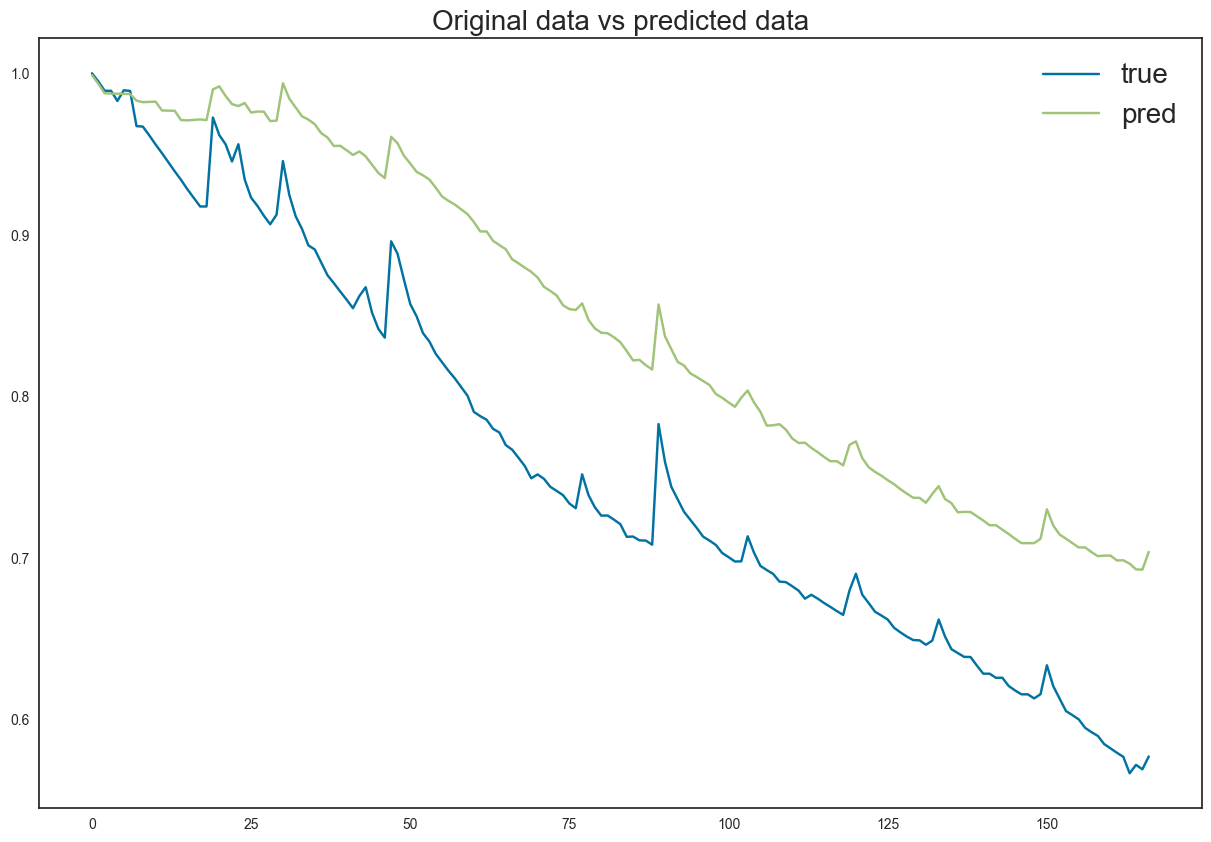

In [69]:
plt.figure(figsize=(15, 10))
plt.plot(raw_values_n[:len(supervised_values_n)], label='true')
plt.plot(prediction_n, label='pred')
plt.legend(fontsize=20)
plt.title('Original data vs predicted data', fontsize=20)
plt.show()